All methods require user authorization. Register the app at your [dashboard](https://developer.spotify.com/dashboard) to get the credentials. When creating the app, select "Web API" and set `http://localhost:8888/callback` as "Redirect URI" (as suggested in a [video](https://youtu.be/3RGm4jALukM) in the Spotipy [documentation](https://spotipy.readthedocs.io)). Then, before running the notebook, set the environment variables of the credentials (client ID and client secret) in your terminal:

* `export SPOTIPY_CLIENT_ID=`...
* `export SPOTIPY_CLIENT_SECRET=`...

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

Tracks are obtained from playlists of different genres. You can get the ID of a playlist from its URL. Some of the genres are:

* [pop](https://open.spotify.com/genre/0JQ5DAqbMKFEC4WFtoNRpw)
* [blues](https://open.spotify.com/genre/0JQ5DAqbMKFQiK2EHwyjcU)
* [country](https://open.spotify.com/genre/0JQ5DAqbMKFKLfwjuJMoNC)
* [rock](https://open.spotify.com/genre/0JQ5DAqbMKFDXXwE9BDJAr)
* [classical](https://open.spotify.com/genre/0JQ5DAqbMKFPrEiAOxgac3)
* [reggae](https://open.spotify.com/genre/0JQ5DAqbMKFJKoGyUMo2hE)
* [disco](https://open.spotify.com/genre/0JQ5DAqbMKFwT0m6BbKvGP) (it was under Dance/Electronic)
* [hiphop](https://open.spotify.com/genre/0JQ5DAqbMKFQ00XGBls6ym)
* [jazz](https://open.spotify.com/genre/0JQ5DAqbMKFAJ5xb0fwo9m)
* [metal](https://open.spotify.com/genre/0JQ5DAqbMKFDkd668ypn6O)

You can search for more genres in [Spotify](https://open.spotify.com/search)

In [2]:
from collections import defaultdict

playlists = {
    'pop': [
        '37i9dQZF1DXcBWIGoYBM5M', '37i9dQZF1DX5gGGog0N2Tu', '37i9dQZF1DX2c7QgpQBJFr', '37i9dQZF1DX7e8TjkFNKWH', '37i9dQZF1DWSpF87bP6JSF',
        '37i9dQZF1DX6ThddIjWuGT', '37i9dQZF1DWYCIYGXn56uz', '37i9dQZF1DX6wfQutivYYr', '37i9dQZF1DWYHO8PTSQ9fM', '37i9dQZF1DWUZMtnnlvJ9p',
        '37i9dQZF1DWTwnEm1IYyoj'],
    'blues': [
        '37i9dQZF1DXd9rSDyQguIk', '37i9dQZF1DXcu3QLJudo4X', '37i9dQZF1DXb3MZdETGqKB', '37i9dQZF1DX7b1e7B17gg7', '37i9dQZF1DX2Pqxel6mitp',
        '37i9dQZF1DXd8nB8TGVGGF', '37i9dQZF1DWWyCCtyRAvGr', '37i9dQZF1DXcc6f6HRuPnq', '37i9dQZF1DX9GnjlK17CLK', '37i9dQZF1DX4MTfCb9IRyO',
        '37i9dQZF1DXbxvVclJxhEJ'],
    'country': [
        '37i9dQZF1DWZBCPUIUs2iR', '37i9dQZF1DWTkxQvqMy4WW', '37i9dQZF1DX1lVhptIYRda', '37i9dQZF1DX7aUUBCKwo4Y', '37i9dQZF1DWXdiK4WAVRUW',
        '37i9dQZF1DXdxUH6sNtcDe', '37i9dQZF1DWVpjAJGB70vU', '37i9dQZF1DX6RCydf9ytsj', '37i9dQZF1DWYP5PUsVbso9', '37i9dQZF1DWYnwbYQ5HnZU',
        '37i9dQZF1DX7CGYgLhqwu5', '37i9dQZF1DX8WMG8VPSOJC', '37i9dQZF1DWYUfsq4hxHWP'],
    'rock': [
        '37i9dQZF1DWZNFWEuVbQpD', '37i9dQZF1DXcF6B6QPhFDv', '37i9dQZF1DWZryfp6NSvtz', '37i9dQZF1DWWJOmJ7nRx0C', '37i9dQZF1DX82GYcclJ3Ug',
        '37i9dQZF1DWW9tK1GiTdMf', '37i9dQZF1DWT2jS7NwYPVI', '37i9dQZF1DX14rbJEM3cke', '37i9dQZF1DXciq74vrQmM8', '37i9dQZF1DWViUlcvfltyZ'],
    'classical': [
        '37i9dQZF1DWWEJlAGA9gs0', '37i9dQZF1DWV0gynK7G6pD', '37i9dQZF1DX17GkScaAekA', '37i9dQZF1DWUvHZA1zLcjW', '37i9dQZF1DWSw8liJZcPOI',
        '37i9dQZF1DX21hEmly67Fg', '37i9dQZF1DX8qqIDAkKiQg', '37i9dQZF1DX12YIlzNkccL', '37i9dQZF1DWZnzwzLBft6A', '37i9dQZF1DXcEKFjZJYZcc'],
    'reggae': [
        '37i9dQZF1DWSiyIBdVQrkk', '37i9dQZF1DXbSbnqxMTGx9', '37i9dQZF1DX7GUbRHVEX42', '37i9dQZF1DWSkkUxEhrBdF', '37i9dQZF1DX2HC3xQbIKZ8',
        '37i9dQZF1DWWgsG1xGbDd1', '37i9dQZF1DXa8n42306eJB', '37i9dQZF1DX3fXJqxGjuEP', '37i9dQZF1DX9udeSemCofA'],
    'disco': [
        '37i9dQZF1DX1MUPbVKMgJE', '37i9dQZF1DX3jWba5xiDhV', '37i9dQZF1DX2GKumqRIZ7g', '37i9dQZF1DXbS8bPVXXR2B', '37i9dQZF1DX00RdhV73Dbe',
        '37i9dQZF1DXattPCMpISJh', '37i9dQZF1DWZXHVUlGM9Wp', '37i9dQZF1DWVBWFXlHC6s7', '37i9dQZF1DWTYPRTIhI2jZ', '37i9dQZF1DXcY6g7fWiKHx'],
    'hiphop': [
        '37i9dQZF1DX14EWeH2Pwf3', '37i9dQZF1DWYQKKZPHGppf', '37i9dQZF1DX37pZLd58ED5', '37i9dQZF1DWYrg01Xmlew6', '37i9dQZF1DWVA1Gq4XHa6U',
        '37i9dQZF1DX186v583rmzp', '37i9dQZF1DWYGxBNe4qojI', '37i9dQZF1DX9sQDbOMReFI', '37i9dQZF1DXdUAMxTn0rVu', '37i9dQZF1DX1lHW2vbQwNN',
        '37i9dQZF1DX76t638V6CA8', '37i9dQZF1DX2sQHbtx0sdt', '37i9dQZF1DWTgSTuHRv7LV', '37i9dQZF1DWYok9l1JL7GM', '37i9dQZF1DWSxF6XNtQ9Rg'],
    'jazz': [
        '37i9dQZF1DXbITWG1ZJKYt', '37i9dQZF1DX55mNLGdHona', '37i9dQZF1DXbehaqJzJXqw', '37i9dQZF1DWT4nLmUaFDGb', '37i9dQZF1DWTbzY5gOVvKd',
        '37i9dQZF1DWVf1Phr4ZVgO', '37i9dQZF1DX6lttj7ulLd6', '37i9dQZF1DWWR73B3Bnjfh', '37i9dQZF1DX5S7hzwhDSyV', '37i9dQZF1DWXj0W55phbFm',
        '37i9dQZF1DX0SM0LYsmbMT'],
    'metal': [
        '37i9dQZF1DWWOaP4H0w5b0', '37i9dQZF1DX1kydukZhLms', '37i9dQZF1DX9qNs32fujYe', '37i9dQZF1DXdiUbJTV2anj', '37i9dQZF1DX9G93rIVMmzM',
        '37i9dQZF1DWTcqUzwhNmKv', '37i9dQZF1DXcfZ6moR6J0G', '37i9dQZF1DWTXGqmP0bfT3', '37i9dQZF1DWY3PJWG3ogmJ', '37i9dQZF1DWXIcbzpLauPS']}

#check uniqueness
genres = defaultdict(list)
for genre, playlists_ in playlists.items():
    for playlist in playlists_:
        genres[playlist].append(genre)
        assert len(genres[playlist]) == 1, (playlist, genres[playlist])

In [3]:
from contextlib import suppress

#get features
features_ = []
for genre, playlists_ in playlists.items():
    for playlist in playlists_:
        tracks = []

        #get track ids, preview urls and genres
        for item in spotify.playlist_tracks(playlist)['items']:
            with suppress(TypeError): #skips missing tracks
                tracks.append({
                    'id': item['track']['id'],
                    'preview_url': item['track']['preview_url'],
                    'genre': genre})

        #get danceability values
        ids = [track['id'] for track in tracks]
        for track, features in zip(tracks, spotify.audio_features(ids)):
            with suppress(TypeError, AssertionError): #skips missing and wrong features
                assert track['id'] == features['id']
                track['danceability'] = features['danceability']

        features_.extend(tracks)
        print('.', end='')
len(features_)

..............................................................................................................

8828

In [4]:
import os
import pandas as pd

#create data directory
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

#save features
features_path = os.path.join(data_dir, 'features.csv')
features = pd.DataFrame(features_).dropna().drop_duplicates('id', ignore_index=True)
features.sample(frac=1, random_state=42).to_csv(features_path, index=False)
features = pd.read_csv(features_path)
features.tail(2)

,id,preview_url,genre,danceability
5463,4dIoimQas4pY5JkvDF88B0,https://p.scdn.co/mp3-preview/929095d181190bed...,metal,0.545
5464,2vY3XKWiQ3gb4o0aXRtHjY,https://p.scdn.co/mp3-preview/cd284d156d553c95...,blues,0.407


In [5]:
from urllib.request import urlretrieve
from concurrent.futures import ThreadPoolExecutor

#create audio directory
audio_dir = os.path.join(data_dir, 'audio')
os.makedirs(audio_dir, exist_ok=True)

def download(row):
    audio_path = os.path.join(audio_dir, f"{row['id']}.mp3")
    urlretrieve(row['preview_url'], audio_path)
    if row.name % 10 == 0:
        print('.', end='')

#download previews
with ThreadPoolExecutor() as executor:
    for result in executor.map(download, features.iloc):
        pass #raises errors if any

...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [6]:
from joblib import delayed, Parallel #ProcessPoolExecutor not working with librosa
import importlib; from utils import preprocessing; importlib.reload(preprocessing) #for debugging purposes
from utils.preprocessing import audio_to_spec

#create spectrogram directory
spec_dir = os.path.join(data_dir, 'spec')
os.makedirs(spec_dir, exist_ok=True)

@delayed
def get_spec(id):
    audio_path = os.path.join(audio_dir, f"{id}.mp3")
    spec_path = os.path.join(spec_dir, f"{id}.png")
    audio_to_spec(audio_path).save(spec_path)

#compute and save spectrograms
with Parallel(n_jobs=-1, verbose=2) as parallel:
    parallel(get_spec(id) for id in features['id'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 5465 out of 5465 | elapsed: 13.7min finished


,id,preview_url,genre,danceability
5464,2vY3XKWiQ3gb4o0aXRtHjY,https://p.scdn.co/mp3-preview/cd284d156d553c95...,blues,0.407


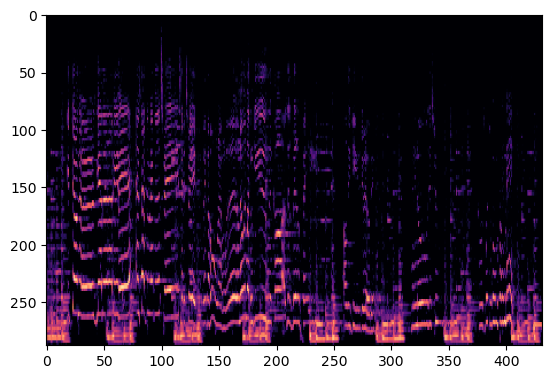

In [7]:
from utils import dataset; importlib.reload(dataset) #for debugging purposes
from utils.dataset import SpectrogramsDataset
import numpy as np
import matplotlib.pyplot as plt

i = -1

#test genre dataset
dataset = SpectrogramsDataset(spec_dir, features_path, target='genre')
spec, label = dataset[i]
assert dataset.classes[label] == features.iloc[i]['genre']

#test danceability dataset
dataset = SpectrogramsDataset(spec_dir, features_path, target='danceability')
spec, label = dataset[i]
assert label == features.iloc[i]['danceability'].astype(np.float32)

plt.imshow(spec)
features.iloc[[i]]